In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from dataset import Dataset
from folder import Folder
from constants import channels, fs

In [2]:
dataset = Dataset('saved_data.pickle', is_loaded=True)
dataset.sumarize_basic_stats(False)

AttributeError: 'FigureManager' object has no attribute 'window'

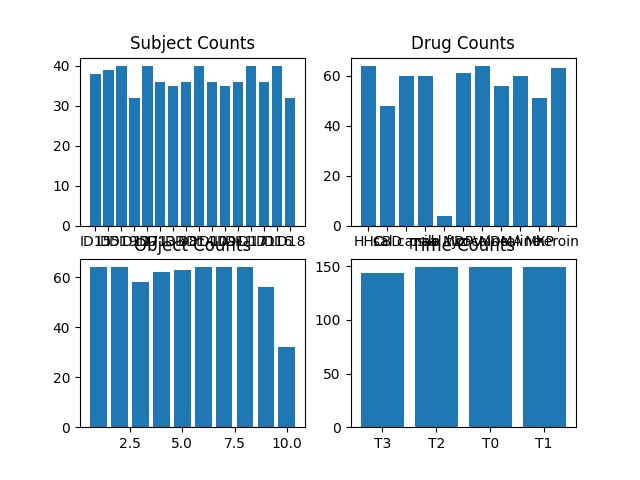

In [3]:
dataset.sumarize_basic_stats()

In [ ]:
del dataset

In [ ]:
dataset.sumarize_basic_stats(False)
channels_sep = dict()
for i, drug in enumerate(dataset.drugs):
    print(f"\r{i  + 1} / {len(dataset.drugs)} - computing {drug}                   ", end='')
    channels_sep[drug] = dataset.get_average_spectrums(drug=drug, time='T2', visualize=False)
print()

(76800,)
['HHC', 'CBD', 'sal canab', 'psilo', 'sal fyz', 'MDPV', 'cocaine', 'MDMA', 'saline', 'MXP', 'heroin']
41


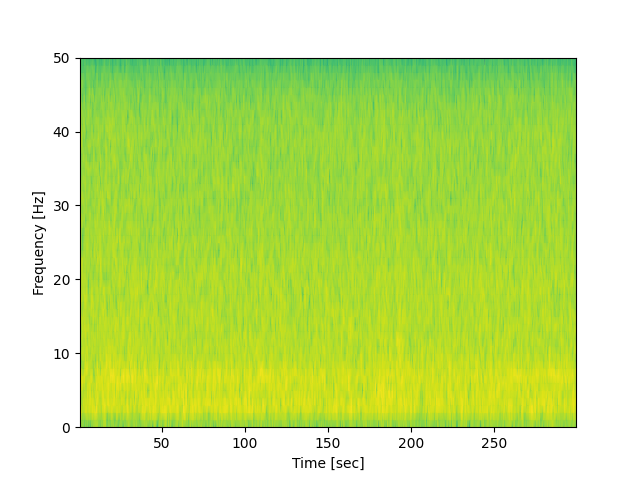

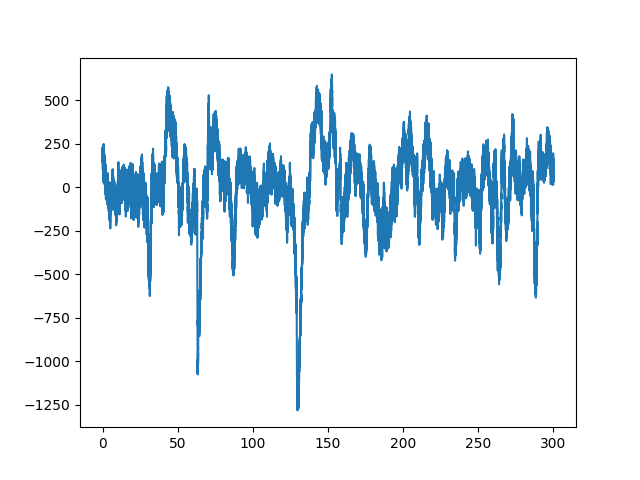

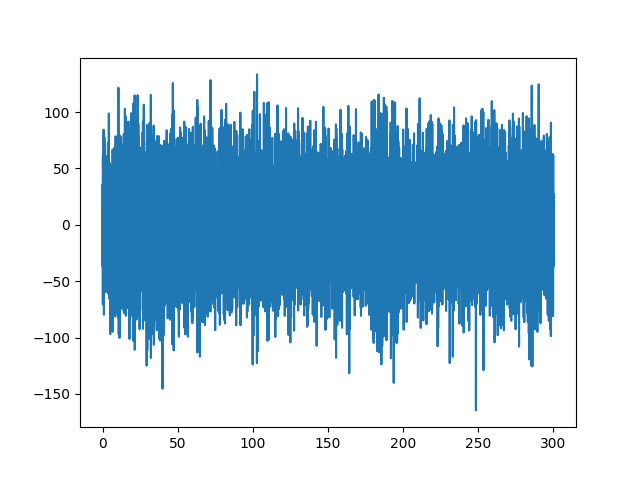

In [9]:
from scipy.signal import spectrogram, iirnotch, butter, filtfilt

sig = dataset.select(drug='MDMA', time='T2')[1]['C1']

b, a = iirnotch(50, Q=30, fs=fs)
sig_f = filtfilt(b, a, sig)
b, a = butter(N=4, Wn=[0.5, 45], btype='bandpass', fs=fs)
sig_f = filtfilt(b, a, sig_f)

f, t, Sxx = spectrogram(sig_f, fs, nperseg=256, noverlap=128)

print(sig.shape)
print(dataset.drugs)
print(np.where(f > 40)[0][0])

#plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.figure()
plt.pcolormesh(t, f, 20 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0, 50])
plt.show()



plt.figure()
t = np.linspace(0, sig.size / fs, sig.size)
plt.plot(t, sig)
plt.show()
plt.figure()
plt.plot(t, sig_f)
plt.show()

In [ ]:
from standard_methods import get_most_common_freq

signal = dataset.select(drug='saline', time='T0')[1]['F1']
print(signal.shape)
cf, f = get_most_common_freq(signal)
print(cf.shape)
plt.plot(f, cf)
plt.xlim([0, 30])
plt.show()


In [ ]:
spectral_dist = dict()
x1 = np.array(channels_sep['psilo'][0])
for i, d1 in enumerate(dataset.drugs):
    for j, d2 in enumerate(dataset.drugs):
        if j < i: continue
        spectral_dist[(d1, d2)] = 0
        for k in range(len(channels)):
            spectral_dist[(d1, d2)] += np.linalg.norm(np.mean(channels_sep[d1][k], axis=0) - np.mean(channels_sep[d2][k], axis=0), ord=2)

sd_mat = np.zeros((18, 18))
for i in range(18):
    for j in range(18):
        sd_mat[i, j] = spectral_dist[(dataset.drugs[i], dataset.drugs[j])]
sd_mat += sd_mat.T


In [ ]:
del dataset